## Tasks

- [x] Between last week and this week, we tried to come up with some questions
  to answer, to piece together all the experimentation up to now.

### Training with degrees of freedom a.k.a. particle orientation

Hypothesis: Cluster formation occurs when two particles collide head on (so
left vs right and up vs down) and form the cluster seed. Due to exclusion,
these seeds are jammed, until they tumble away. Hence at the center of the
clusters, we expect the network to pick up on these (1-3, 2-4) configurations.
At the edges, we expect particles to point towards the clusters. This means
there is a difference between the "colourful" and the "monochromatic" one.
Because of this, we expect the "cross-prediction" (i.e. taking a dataset with
orientation and asking a model trained without orientation for predictions) to
perform poorly, as the networks will be looking for something completely
differently.

- **Experiment 1a**: inject into the model information on the 4 degrees of freedom and predict with
  and without this information (i.e. merely positions, this is experiment-like).
  - **Outcome:** Prediction **without** orientation performs much poorer compared to
    prediction **with** orientation.
  - **Models:** `magic7474`, `buckwheat3306`
- **Experiment 1b**: train only on positions and predict on data with and
  without the degrees of freedom injected.
  - **Outcome:** Prediction **with** orientation fails completely.
  - **Models:** `failing2399`

#### Plots for training with orientation

Trained on SGD, with a learning rate of 0.008, for 45 epochs.

In [1]:
#| code-fold: true
import os
os.chdir("/hades/projects/persistent-exclusion-process/")
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from src.training_utils import extract_floats, data_load, split_dataset, predict_and_plot
from src.models import make_net

np.set_printoptions(precision=3, suppress=True)

2024-02-29 17:49:13.302023: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 17:49:13.302093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 17:49:13.337158: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 17:49:13.415338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 17:49:14.267255: W tensorflow/compiler/tf2

**With the same data**

In [3]:
#| code-fold: true
x,y,shape = data_load(densities=[0.2], orientation=True)
_, _, x_val, y_val = split_dataset(x,y,last=int(len(x)*0.2))
name = "magic7474"
model = tf.keras.models.load_model(f"models/{name}.keras")

Number of unique alpha:  10
Shape of x:  (30000, 128, 128, 1)
Shape of y:  (30000,)
Size of training data:  24000
Size of validation data:  6000


2024-02-29 17:51:50.977357: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 393216000 exceeds 10% of free system memory.


188/188 [==============================] - 3s 16ms/step
Overlap ratio: 0.7
(Min, Max, Avg) STD: 0.0022416604 0.034824748 0.011316802
Pearson's correlation coeff:  0.992173827540833
Overlap ratio: 0.7
(Min, Max, Avg) STD: 0.0022416604 0.034824748 0.011316802
Pearson's correlation coeff:  0.992173827540833


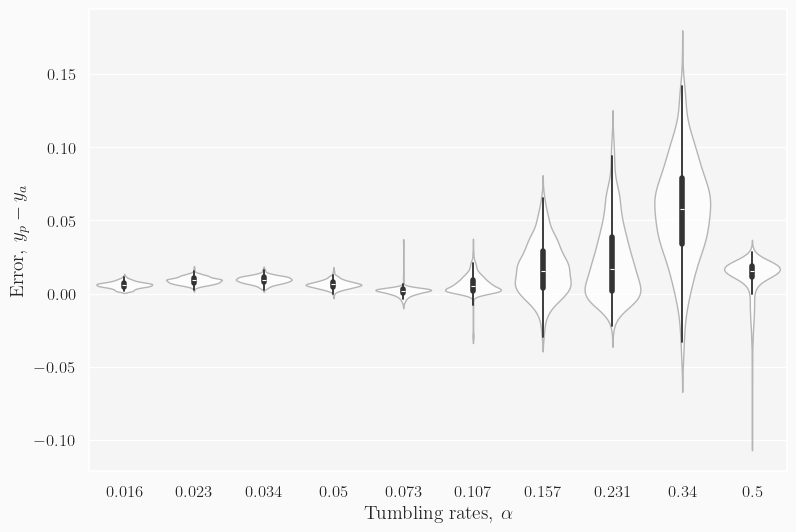

In [4]:
predict_and_plot(model, x_val, y_val)

**With data where orientation is removed (binarized)**

  5/913 [..............................] - ETA: 13s 

2024-02-29 17:52:07.912672: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1913651200 exceeds 10% of free system memory.


913/913 [==============================] - 14s 16ms/step
Overlap ratio: 0.3
(Min, Max, Avg) STD: 0.0 0.06442532 0.024747767
Pearson's correlation coeff:  0.13855496918568383
Overlap ratio: 0.3
(Min, Max, Avg) STD: 0.0 0.06442532 0.024747767
Pearson's correlation coeff:  0.13855496918568383


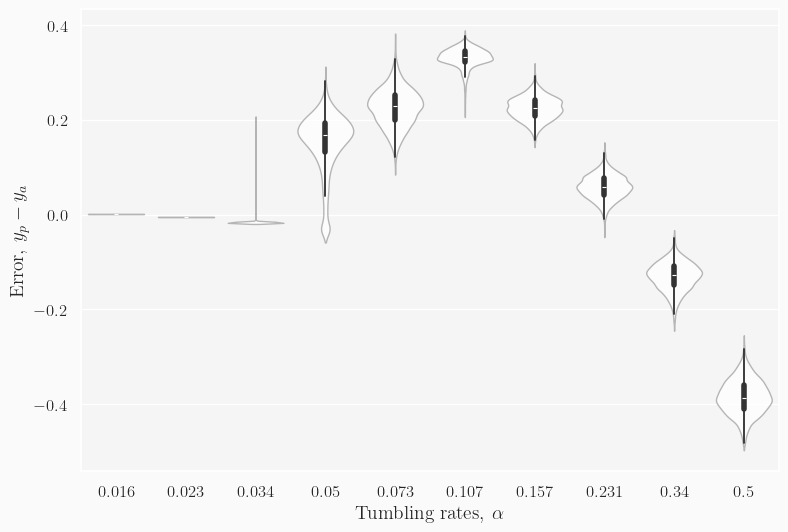

In [5]:
del x,y,x_val,y_val
x,y,shape = data_load(densities=[0.2], orientation=False)
predict_and_plot(model, x[:800], y[:800])

With orientation removed, the model trained on orientation seems to overpredict
the orientations, and cannot tell at all what's happening at high $\alpha$'s,
where it cannot distinguish 0.231 and 0.340 from 0.500.

To visualize what's going on, here are the snapshots at $\alpha = 0.340, 0.500$:

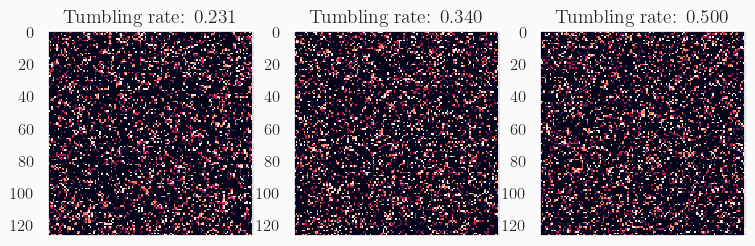

In [12]:
#| code-fold: true
import os
os.chdir("/hades/projects/persistent-exclusion-process/")
import h5py
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(9,3))

values = ["0.231","0.340", "0.500"]

for idx, ax in enumerate(np.array(axes).reshape(-1)):
  with h5py.File(f"no_roll_data/dataset_tumble_{values[idx]}_0.25.h5", "r") as fin:
      count = 0
      img = fin[list(fin.keys())[-1]][:]
      ax.matshow(img)
      ax.grid(False)
      ax.set_xticks([])
      ax.set_title(f"Tumbling rate: {values[idx]}")

To the human eyes, these are very similar. It is possible the network learns
from the orientation here, seeing more 1-3 and 2-4 configurations for the lower
values of $\alpha$'s, since more clustering happens. This would mean removing
orientation as information makes the network fail to distinguish.

The regime where it overpredicts is also interesting, although I'm not quite
sure why this is happening.

The same kind of experiment, but with $\phi = 0.4$ instead:

#### Plots for training without orientation

**With the same data**

Number of unique alpha:  10
Shape of x:  (30000, 128, 128, 1)
Shape of y:  (30000,)
Size of training data:  24000
Size of validation data:  6000
  5/188 [..............................] - ETA: 2s 

2024-02-29 17:54:17.299810: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 393216000 exceeds 10% of free system memory.


188/188 [==============================] - 3s 14ms/step
Overlap ratio: 1.0
(Min, Max, Avg) STD: 0.0020176726 0.03462249 0.01297331
Pearson's correlation coeff:  0.9852125254093039
Overlap ratio: 1.0
(Min, Max, Avg) STD: 0.0020176726 0.03462249 0.01297331
Pearson's correlation coeff:  0.9852125254093039


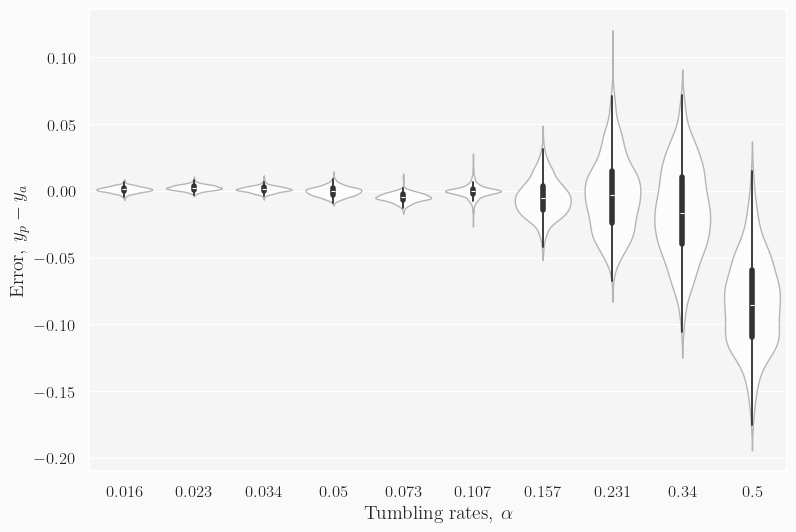

In [13]:
#| code-fold: true
del x,y, model
x,y,shape = data_load(densities=[0.2], orientation=False)
_, _, x_val, y_val = split_dataset(x,y,last=int(len(x)*0.2))
name = "failing2399"
model = tf.keras.models.load_model(f"models/{name}.keras")
predict_and_plot(model, x_val, y_val)

**Orientation added into data**

16/16 [==============================] - 0s 14ms/step
Overlap ratio: 0.0
(Min, Max, Avg) STD: 0.00018386112 0.0018590111 0.001102606
Pearson's correlation coeff:  0.9107537153185321
Overlap ratio: 0.0
(Min, Max, Avg) STD: 0.00018386112 0.0018590111 0.001102606
Pearson's correlation coeff:  0.9107537153185321


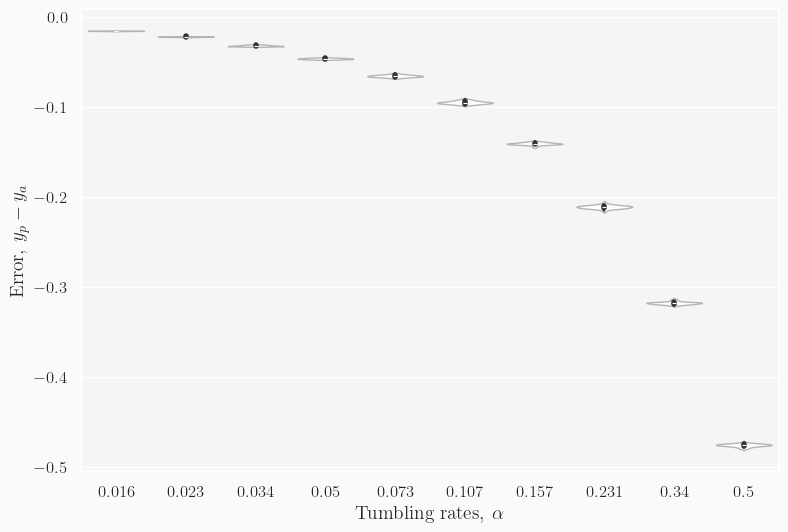

In [16]:
#| code-fold: true
del x,y,x_val,y_val
x,y,shape = data_load(densities=[0.2], orientation=True)
predict_and_plot(model, x[:500], y[:500])

Adding orientation to the snapshots makes the model completely fail to predict
any meaningful $\alpha$. It does not predict a single value within the accuracy
defined. My guess is that the way the model has learned is to potentially only
see blobs as clusters, so when individual pixels can be distinguished from
their defining "brightness" (grayscale image with five values 0 (background),
0.25, 0.5, 0.75, 1), it cannot see them as clusters no longer. Instead, a lot
of "noise" is now present. Yet, the model was not trained on noise, so it's not
surprising that it cannot handle noise.

#### Performance between the two experiment

Overall, they perform the same, with loss and different metrics for standard
deviation within a similar ball park figure:

- $\delta_{\mathrm{MAE}}\approx 0.02$
- $\sigma_{\mathrm{max}}$ in the range $0.04,0.05$.
- $\sigma_{\mathrm{mean}}$ in the range $0.01,0.02$.
- Overlap ratios are both 1.0.
- $r \approx 0.99$.

I think for experiment-like, it is best to inject noise into the training
dataset. Injecting noise reduces overfitting and increases robustness, as it is
a form of augmentation.

## Reference materials

- [Data Augmentation in Training CNNS: Injecting Noise to Images](https://arxiv.org/abs/2307.06855)
- [Noise to reduce overtting](https://machinelearningmastery.com/train-neural-networks-with-noise-to-reduce-overfitting/)
- [Similar to above](https://machinelearningmastery.com/how-to-improve-deep-learning-model-robustness-by-adding-noise/)
- [Noise models for CNNs](https://www.sciencedirect.com/science/article/pii/S2590123021000268)